<a href="https://colab.research.google.com/github/omar80-coder/fine-tuning-a-LayoutLMv3-model-for-Named-Entity-Recognition-NER/blob/main/cross_entropy_LMv3_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
    # Set the default device to GPU
    torch.cuda.set_device(0)
else:
    print("CUDA is not available. Running on CPU.")


CUDA is not available. Running on CPU.


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install transformers datasets torch
!pip install imgaug
!pip install seqeval
!pip install transformers[torch]
!pip install accelerate -U
!pip install pdf2image
!pip install pymupdf
!pip install albumentations
!pip install evaluate
!pip install optuna

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached

In [ ]:
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification,AutoProcessor
from PIL import Image, ImageDraw
import numpy as np
import tqdm as notebook_tqdm
import json
import pandas as pd
import os
from pdf2image import convert_from_path
import fitz  # PyMuPDF
import glob
import matplotlib.pyplot as plt
import cv2
from skimage import io
from PIL import Image, ImageDraw, ImageFont
import torch
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from torch.utils.data import DataLoader, Dataset
from datasets import load_metric
from torch.optim import AdamW
from torch.utils.data import DataLoader

In [ ]:
def read_annotation_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

In [ ]:
#Testing of the function  (it workded)

annotation_data= read_annotation_file("/content/drive/MyDrive/finaly/20221109_144858.pdf_1.json") # Updated path to include the actual JSON file

annotation_data

{'path': 'resized_hands/20221109_144858.pdf_1.png',
 'width': 600,
 'height': 900,
 'ner_tags': [0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  6,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  0,
  4],
 'words': ['KHELIFI',
  'YOUSSEF',
  'Facture',
  'No',
  "000420'",
  '10,Rue',
  'Le',
  'HRAIRIA,',
  'Ezzouhour',
  '4,',
  'Tunis',
  'E-mail:',
  'khlifilocation@gmail.com',
  'Date',
  ':',
  '04/08',
  '2022',
  'Page',
  'FB:',
  'KHLIFI-Décor',
  'de',
  'mariage',
  '&',
  'événementiel',
  'Tél',
  ':',
  '26',
  '902',
  '542',
  'Tél:',
  '31',
  '160',
  '944',
  '-',
  '

(600, 900)


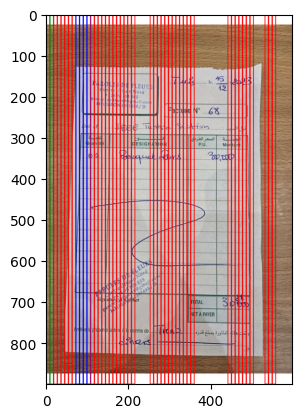

fin


In [ ]:
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt

def display_image_with_ner_tags(image_path, json_path, color_map={'0': 'red', '1': 'green', '2': 'blue'}):
    # Load the image and convert to RGB
    image = Image.open(image_path).convert("RGB")
    print(image.size)
    draw = ImageDraw.Draw(image)
    with open(json_path, 'r') as file:
        annotations = json.load(file)

    # Assuming each tag corresponds to a region of equal size
    # You'll likely need to adjust this based on your actual tokenization
    region_width = image.width // len(annotations['ner_tags'])
    region_height = image.height

    # Draw rectangles for each tag
    for i, tag in enumerate(annotations['ner_tags']):
        tag_str = str(tag) # Convert tag to string for color mapping
        if tag_str in color_map:
            color = color_map[tag_str]
            x1 = i * region_width
            y1 = 0
            x2 = (i + 1) * region_width
            y2 = region_height
            draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

    # Display using Matplotlib
    plt.imshow(image)
    plt.show()
    print("fin")

# Test the function (replace with your actual paths)
annotation_path = "/content/drive/MyDrive/finaly/20231217_190133_merged-24.pdf_1.json"
image_path = "/content/drive/MyDrive/resized_hand/20231217_190133_merged-2.pdf_1.png"
display_image_with_ner_tags(image_path, annotation_path)

# Data Augmentation

In [ ]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.MedianBlur(blur_limit=3, p=0.3),
        A.ColorJitter(p=0.3),
        A.PadIfNeeded(min_height=1000, min_width=700, border_mode=cv2.BORDER_CONSTANT, value=[255, 255, 255], p=1.0),
        A.Rotate(limit=5, p=1, interpolation=cv2.INTER_CUBIC),
    ], bbox_params=A.BboxParams(
        format='pascal_voc',
        label_fields=['labels'],
        min_area=0,
        min_visibility=0.1
    ))

# LayoutLmv3

## Label Dictionaries:

In [ ]:
label2id = {
    'O': 0,
    'B-title': 1,
    'I-title': 2,
    'B-date': 3,
    'I-date': 4,
    'B-ieee': 5,
    'I-ieee': 6,
    'B-total': 7,
    'I-total': 8,
    'B-totalValue': 9,
    'I-totalValue': 10
}

# Create id2label by reversing label2id
id2label = {id: label for label, id in label2id.items()}

## Processor Initializationng

In [ ]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)  #we will be provindg the ocr information load a pre-trained model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Custom Dataset Class:

In [ ]:
def crop_to_bounding_boxes(image_np, boxes):
        if not boxes:
            return image_np  # Return original if no boxes

        # Initialize min and max coordinates with values from the first box
        x_min = boxes[0][0]
        y_min = boxes[0][1]
        x_max = boxes[0][2]
        y_max = boxes[0][3]

        # Iterate over all boxes to find the minimum and maximum extents
        for box in boxes:
            x_min = min(x_min, box[0])
            y_min = min(y_min, box[1])
            x_max = max(x_max, box[2])
            y_max = max(y_max, box[3])

        # Crop the image using the min and max coordinates
        image_cropped = image_np[y_min-20:y_max+20, x_min-20:x_max+20]

        adjusted_boxes = []
        for box in boxes:
            adjusted_box = [
                box[0] - x_min+20 ,
                box[1] - y_min+20,
                box[2] - x_min+20,
                box[3] - y_min+20
            ]
            adjusted_boxes.append(adjusted_box)

        return image_cropped, adjusted_boxes


In [ ]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, annotation_dir, image_dir, annotation_files, transforms=None):
        self.annotations = [os.path.join(annotation_dir, file) for file in annotation_files]
        self.image_dir = image_dir
        self.processor = processor
        self.transforms = transforms

    def __getitem__(self, idx):
        annotation_path = self.annotations[idx]
        with open(annotation_path, 'r') as f:
            data = json.load(f)

        image_path = os.path.join(self.image_dir, os.path.basename(data["path"]))
        image = Image.open(image_path).convert("RGB")

        width, height = image.size

        words = data["words"]
        print(words)
        labels = [label2id[label] for label in data["ner_tags"]]
        boxes = data["bboxes"]

        image_np = np.array(image)  # Convert PIL Image to NumPy array for transformation
        # print(f"Before transformation: {len(words)} words, {len(boxes)} boxes")

        if self.transforms:
            transformed = self.transforms(image=image_np, bboxes=boxes, labels=labels)
            image_np = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']

        boxes = [[int(box[0]), int(box[1]), int(box[2]), int(box[3] )] for box in boxes]
        cropped_image, boxes = crop_to_bounding_boxes(image_np, boxes)

        image = Image.fromarray(cropped_image)
        image = image.resize((600, 900))
        width, height = image.size

        boxes = [[bbox[0] / width, bbox[1] / height, bbox[2] / width, bbox[3] / height] for bbox in boxes]
        boxes = [[int(box[0] * 1000), int(box[1] * 1000), int(box[2] * 1000), int(box[3] * 1000)] for box in boxes]

        image.convert("RGB")
        encoding = self.processor(image, words, boxes=boxes, word_labels=labels, truncation=True, padding="max_length", return_tensors="pt")
        bbox_tensor = torch.tensor(boxes, dtype=torch.long)
        label_tensor = torch.tensor(labels, dtype=torch.long)

        return {
            'words': words,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'bbox': bbox_tensor,
            'labels': label_tensor
        }

    def __len__(self):
        return len(self.annotations)

    def check_and_adjust_boxes(self, boxes, img_width, img_height):
        adjusted_boxes = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            if x_min < 0 or y_min < 0 or x_max > img_width or y_max > img_height:
                # Box is out of bounds, adjust or discard
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(img_width, x_max)
                y_max = min(img_height, y_max)
            adjusted_boxes.append([x_min, y_min, x_max, y_max])
        return adjusted_boxes



In [ ]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch import clamp

def crop_to_bounding_boxes(image_np, boxes):
        if not boxes:
            return image_np  # Return original if no boxes

        # Initialize min and max coordinates with values from the first box
        x_min = boxes[0][0]
        y_min = boxes[0][1]
        x_max = boxes[0][2]
        y_max = boxes[0][3]

        # Iterate over all boxes to find the minimum and maximum extents
        for box in boxes:
            x_min = min(x_min, box[0])
            y_min = min(y_min, box[1])
            x_max = max(x_max, box[2])
            y_max = max(y_max, box[3])

        # Crop the image using the min and max coordinates
        image_cropped = image_np[y_min-20:y_max+20, x_min-20:x_max+20]

        adjusted_boxes = []
        for box in boxes:
            adjusted_box = [
                box[0] - x_min+20 ,
                box[1] - y_min+20,
                box[2] - x_min+20,
                box[3] - y_min+20
            ]
            adjusted_boxes.append(adjusted_box)

        return image_cropped, adjusted_boxes
def clamp_values(value, min_value, max_value):
    return max(min_value, min(value, max_value))

class CustomDataset(Dataset):
    def __init__(self, annotation_dir, image_dir, annotation_files, transforms=None):
        self.annotations = [os.path.join(annotation_dir, file) for file in annotation_files]
        self.image_dir = image_dir
        self.processor = processor
        self.transforms = transforms

    def __getitem__(self, idx):
        annotation_path = self.annotations[idx]
        with open(annotation_path, 'r') as f:
            data = json.load(f)

        image_path = os.path.join(self.image_dir, os.path.basename(data["path"]))
        image = Image.open(image_path).convert("RGB")

        width, height = image.size

        words = data["words"]
        labels = [label2id[label] for label in data["ner_tags"]]
        boxes = data["bboxes"]

        image_np = np.array(image)  # Convert PIL Image to NumPy array for transformation
        # print(f"Before transformation: {len(words)} words, {len(boxes)} boxes")

        if self.transforms:
            transformed = self.transforms(image=image_np, bboxes=boxes, labels=labels)
            image_np = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']


        boxes = [[int(box[0]), int(box[1]), int(box[2]), int(box[3] )] for box in boxes]
        cropped_image, boxes = crop_to_bounding_boxes(image_np, boxes)

        boxes = [[int(box[0]), int(box[1]), int(box[2]), int(box[3] )] for box in boxes]


        image = Image.fromarray(cropped_image)
        image = image.resize((600, 900), resample=Image.BILINEAR)
        # boxes = normalize_bboxes(boxes, 600, 900)
        # boxes = [[int(box[0]), int(box[1]), int(box[2]), int(box[3] )] for box in boxes]

        boxes = [[bbox[0] / width, bbox[1] / height, bbox[2] / width, bbox[3] / height] for bbox in boxes]
        boxes = [[int(box[0] * 1000), int(box[1] * 1000), int(box[2] * 1000), int(box[3] * 1000)] for box in boxes]

        boxes = [[clamp_values(coord, 0, 1000) for coord in box] for box in boxes]

        image.convert("RGB")
        encoding = self.processor(image, words, boxes=boxes, word_labels=labels, truncation=True, padding="max_length", return_tensors="pt")
        bbox_tensor = torch.tensor(boxes, dtype=torch.long)
        label_tensor = torch.tensor(labels, dtype=torch.long)

        return {
            'words': words,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'bbox': bbox_tensor,
            'labels': label_tensor
        }

    def __len__(self):
        return len(self.annotations)


In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import pickle
annotation_dir = "/content/drive/MyDrive/finaly"
image_dir = "/content/drive/MyDrive/resized_hand"
annotation_files = [file for file in os.listdir(annotation_dir) if file.endswith('.json')]
np.random.shuffle(annotation_files)
split_idx = int(0.8 * len(annotation_files))
train_files = annotation_files[:split_idx]
test_files = annotation_files[split_idx:]
train_dataset = CustomDataset(annotation_dir, image_dir, annotation_files=train_files,transforms=get_train_transform()) #,transforms=get_train_transform()
test_dataset = CustomDataset(annotation_dir, image_dir, annotation_files=test_files)

data_to_save = {
    'train_files': train_files,
    'test_files': test_files
}

with open('dataset.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

#Create 2

In [ ]:
#check coherence

def count_files_in_directory(directory):
    count = 0
    for path in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, path)):
            count += 1
    return count

print(f"Number of files in directory Resized_images: {count_files_in_directory('/content/drive/MyDrive/resized_hand')}")
print(f"Number of files in directory outputs: {count_files_in_directory('/content/drive/MyDrive/result_json')}")
print(f"Number of files in directory Prerocdes images: {count_files_in_directory('/content/drive/MyDrive/resized_hand')}")
print(f"Number of files in directory Prerocdes annotations: {count_files_in_directory('/content/drive/MyDrive/finaly')}")


Number of files in directory Resized_images: 150
Number of files in directory outputs: 137
Number of files in directory Prerocdes images: 150
Number of files in directory Prerocdes annotations: 137


In [ ]:
# for i in range (1,156):
#     # print(i)
example = train_dataset[0]
# print(example)
# image= example["image"]
# print(image)
id=example["input_ids"]
words = example["words"]
boxes = example["bbox"]
ner_tags = example["labels"]
print(id)
print(f"words: {words}")
print(f"boxes: {boxes}")
print(f"ner_tags: {ner_tags}")
    # ids= example["input_ids"]
    # masks= example["attention_mask"]
    # print("masks:", masks)
    # print("ids:", ids)

    # print(len(words),boxes.size() ,ner_tags.size() )
    # print("Bounding Boxes:", boxes.size())
    # # print("Bounding Boxes:", boxes)
    # print("NER Tags:", ner_tags.size())
    # print(boxes.shape)
    # print(ner_tags.shape)
    # print(ner_tags)
    # print(len(words))

KeyError: 0

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    max_len = max([len(item['input_ids']) for item in batch])
    input_ids = torch.stack([torch.cat([item['input_ids'], torch.tensor([processor.tokenizer.pad_token_id] * (max_len - len(item['input_ids'])), dtype=torch.long)]) for item in batch])
    attention_mask = torch.stack([torch.cat([item['attention_mask'], torch.tensor([0] * (max_len - len(item['attention_mask'])), dtype=torch.long)]) for item in batch])

    bbox_padded = []
    for item in batch:
        padding_length = max_len - item['bbox'].shape[0]
        padded_bbox = torch.cat([item['bbox'], torch.zeros(padding_length, 4, dtype=torch.int64)])
        bbox_padded.append(padded_bbox)
    bbox = torch.stack(bbox_padded)

    labels = torch.stack([torch.cat([item['labels'], torch.tensor([-100] * (max_len - len(item['labels'])), dtype=torch.long)]) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'bbox': bbox,
        'labels': labels
    }

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

In [ ]:
for batch in train_loader:
    print({k: v.shape for k, v in batch.items()})

print(train_loader)

KeyError: 0

# Define metrics

# Define the model

In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    id2label=id2label,
    label2id=label2id)



Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
import evaluate

# deprecated
# from datasets import load_metric
# metric = load_metric("seqeval")

metric = evaluate.load("seqeval")
label_list = list(model.config.id2label.values())


def compute_metrics(p, return_entity_level_metrics=False):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Set zero_division=1 to handle classes with no predictions gracefully
    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)
    if return_entity_level_metrics:
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
# from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
# from transformers import LiltForTokenClassification
# # huggingface hub model id
# model_id = "SCUT-DLVCLab/lilt-roberta-en-base"
# # load model with correct number of labels and mapping
# model = LiltForTokenClassification.from_pretrained(
#     model_id, num_labels=11, label2id=label2id, id2label=id2label
# )

In [ ]:
# # Utilisez cette ligne pour créer l'optimiseur
# optimizer = AdamW(model.parameters(), lr=5e-3, no_deprecation_warning=True)
# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Define TrainingArguments + Trainer


In [ ]:
from transformers import TrainingArguments, Trainer

# MLFlow

In [ ]:
!git clone https://github.com/akramLh005/PFA-mlflow.git
!cd PFA-mlflow


'git' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.
Le chemin d’accès spécifié est introuvable.


In [ ]:
#!pip install mlflow==2.11.1

In [ ]:
%env MLFLOW_TRACKING_URI=https://dagshub.com/akramLh005/PFA-mlflow.mlflow
%env MLFLOW_TRACKING_USERNAME=akramLh005
%env MLFLOW_TRACKING_PASSWORD=fabaf87fce39ef7e9bfdd406d6be4354ce2a25f4


env: MLFLOW_TRACKING_URI=https://dagshub.com/akramLh005/PFA-mlflow.mlflow
env: MLFLOW_TRACKING_USERNAME=akramLh005
env: MLFLOW_TRACKING_PASSWORD=fabaf87fce39ef7e9bfdd406d6be4354ce2a25f4


# Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from torch.nn.utils import clip_grad_norm_

def check_gradient(model):
    def hook(grad):
        if torch.isnan(grad).any() or torch.isinf(grad).any():
            print("NaN or Inf in gradients.")

    for p in model.parameters():
        p.register_hook(hook)



In [ ]:
def calculate_class_counts(dataset):
    # Initialiser un dictionnaire pour compter les occurrences de chaque classe
    class_counts = {label: 0 for label in label2id.values()}

    # Parcourir le jeu de données
    for i in range(len(dataset)):
        sample = dataset[i]
        labels = sample['labels'].numpy()  # Assurez-vous que les labels sont sous forme de Numpy array pour comptage

        # Compter chaque label
        for label in labels:
            if label != -100:  # Assurez-vous de ne pas compter les labels de padding
                class_counts[label] += 1

    return class_counts

# Appliquez cette fonction à votre jeu de données d'entraînement
class_counts = calculate_class_counts(train_dataset)
class_counts_list = [class_counts[i] for i in range(len(label2id))]  # Transformer en liste pour l'usage ultérieur

print("Comptages de classes :", class_counts_list)


Comptages de classes : [6628, 111, 30, 87, 81, 147, 268, 89, 55, 89, 23]


In [ ]:
class_counts = [24869, 134, 36, 148, 42, 129, 299, 151, 109, 147, 31]  # Comptages fournis
total_count = sum(class_counts)
class_weights = [total_count / count for count in class_counts]

# Convertir en tensor de poids pour PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

total_count = sum(class_counts)
class_weights = [total_count / (count + 1e-5) for count in class_counts]  # Small epsilon to avoid division by zero


# Afficher les poids calculés pour chaque classe
print("Poids pour chaque classe :", class_weights)
from torch import nn
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
model.to(device)


Poids pour chaque classe : [1.0492983227917092, 194.73879143740362, 724.8609097608584, 176.3175556542192, 621.30937587872, 202.2868060242786, 87.27424457276774, 172.8145580917511, 239.40364776113321, 177.51699472673505, 841.7739220084122]


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-100)

In [ ]:
import torch
torch.autograd.set_detect_anomaly(True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [ ]:
# from transformers import TrainingArguments, Trainer, AdamW, get_scheduler
# import mlflow
# from transformers import EarlyStoppingCallback

# from torch.optim import AdamW

# weight_decay_rate = 0.01
# mlflow.end_run()
# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     max_grad_norm=1.0,
#     evaluation_strategy="steps",
#     eval_steps=50,
#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=2,
#     num_train_epochs=50,
#     learning_rate=5e-5,
#     logging_dir='./logs',
#     logging_strategy="steps",
#     logging_steps=200,
#     weight_decay = 0.01,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     max_steps=2000,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
#     greater_is_better=True,
# )

# class MLflowTrainer(Trainer):
#     def __init__(self, class_weights_tensor, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-100)

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         loss = self.loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

#     def training_step(self, model, inputs):
#         model.train()
#         inputs = self._prepare_inputs(inputs)
#         with self.autocast_smart_context_manager():
#             loss = self.compute_loss(model, inputs)
#         if self.args.gradient_accumulation_steps > 1:
#             loss /= self.args.gradient_accumulation_steps
#         self.accelerator.backward(loss)
#         if self.args.max_grad_norm is not None:
#             clip_grad_norm_(model.parameters(), self.args.max_grad_norm)
#         logs = {"loss": loss.item()}
#         self.log(logs)
#         return loss.detach()

#     def log(self, logs):
#         super().log(logs)
#         for key, value in logs.items():
#             mlflow.log_metric(key, value, step=self.state.global_step)

#     def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
#         output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
#         for key, value in output.items():
#             mlflow.log_metric(f"{metric_key_prefix}_{key}", value, step=self.state.global_step)

# trainer = MLflowTrainer(
#     class_weights_tensor=class_weights_tensor,
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=processor,
#     data_collator=custom_collate_fn,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
# )

# optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=weight_decay_rate)
# num_training_steps = training_args.max_steps
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=int(0.1 * num_training_steps),
#     num_training_steps=num_training_steps
# )
# training_args.lr_scheduler_type = 'linear'
# training_args.lr_scheduler_num_warmup_steps = int(0.1 * num_training_steps)
# mlflow.start_run()
# trainer.train(resume_from_checkpoint = False)
# mlflow.end_run()




In [ ]:
#My try withotu ml flow

# from transformers import Trainer, EarlyStoppingCallback
# from transformers import TrainingArguments
# import torch
# import torch.nn as nn
# from torch.nn.utils import clip_grad_norm_




# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     max_grad_norm=1.0,
#     evaluation_strategy="steps",
#     eval_steps=50,
#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=2,
#     num_train_epochs=50,
#     learning_rate=5e-5,
#     logging_dir='./logs',
#     logging_strategy="steps",
#     logging_steps=200,
#     weight_decay=0.01,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     max_steps=2000,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
#     greater_is_better=True,
# )



# class CustomTrainer(Trainer):
#     def __init__(self, class_weights_tensor, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-100)

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         loss = self.loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

#     def training_step(self, model, inputs):
#         model.train()
#         inputs = self._prepare_inputs(inputs)
#         with self.autocast_smart_context_manager():
#             loss = self.compute_loss(model, inputs)
#         if self.args.gradient_accumulation_steps > 1:
#             loss /= self.args.gradient_accumulation_steps
#         self.accelerator.backward(loss)
#         if self.args.max_grad_norm is not None:
#             clip_grad_norm_(model.parameters(), self.args.max_grad_norm)
#         logs = {"loss": loss.item()}
#         self.log(logs)
#         return loss.detach()


# weight_decay_rate = 0.01
# optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=weight_decay_rate)

# num_training_steps = training_args.max_steps
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=int(0.1 * num_training_steps),
#     num_training_steps=num_training_steps
# )

# training_args.lr_scheduler_type = 'linear'
# training_args.lr_scheduler_num_warmup_steps = int(0.1 * num_training_steps)
# trainer = CustomTrainer(
#     class_weights_tensor=class_weights_tensor,
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=processor,
#     data_collator=custom_collate_fn,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
# )

# trainer.train(resume_from_checkpoint=True)


In [ ]:
# from transformers import TrainingArguments, Trainer, AdamW, get_scheduler
# import torch
# import mlflow
# from transformers import EarlyStoppingCallback
# from torch.nn import functional as F

# mlflow.end_run()

# weight_decay_rate = 0.01

# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     max_grad_norm=1.0,
#     evaluation_strategy="steps",
#     eval_steps=50,
#     save_strategy="steps",
#     save_steps=200,
#     save_total_limit=2,
#     num_train_epochs=50,
#     learning_rate=5e-4,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     fp16=True,
#     weight_decay=weight_decay_rate,
#     max_steps=1800,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
#     greater_is_better=True,
# )
# class MLflowTrainer(Trainer):
#     def __init__(self, class_weights_tensor, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights_tensor = class_weights_tensor

#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels")
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         # Compute Focal Loss
#         loss = self.focal_loss(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

#     def focal_loss(self, logits, labels, alpha=0.25, gamma=2, reduction='mean'):
#         cross_entropy = F.cross_entropy(logits, labels, reduction='none')
#         pt = torch.exp(-cross_entropy)
#         focal_loss = (alpha * (1 - pt) ** gamma * cross_entropy).mean()
#         return focal_loss

#     def training_step(self, model, inputs):
#         model.train()
#         inputs = self._prepare_inputs(inputs)
#         with self.autocast_smart_context_manager():
#             loss = self.compute_loss(model, inputs)
#         if self.args.gradient_accumulation_steps > 1:
#             loss /= self.args.gradient_accumulation_steps
#         self.accelerator.backward(loss)
#         if self.args.max_grad_norm is not None:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), self.args.max_grad_norm)
#         logs = {"loss": loss.item()}
#         self.log(logs)
#         return loss.detach()

#     def log(self, logs):
#         super().log(logs)
#         for key, value in logs.items():
#             mlflow.log_metric(key, value, step=self.state.global_step)

#     def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
#         output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
#         for key, value in output.items():
#             mlflow.log_metric(f"{metric_key_prefix}_{key}", value, step=self.state.global_step)

# trainer = MLflowTrainer(
#     class_weights_tensor=class_weights_tensor,
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     tokenizer=processor,
#     data_collator=custom_collate_fn,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
# )

# optimizer = AdamW(model.parameters(), lr=5e-4 , weight_decay=weight_decay_rate)
# num_training_steps = training_args.max_steps
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=int(0.1 * num_training_steps),
#     num_training_steps=num_training_steps
# )
# training_args.lr_scheduler_type = 'linear'
# training_args.lr_scheduler_num_warmup_steps = int(0.1 * num_training_steps)
# mlflow.start_run()
# trainer.train()
# mlflow.end_run()



# 51 F1

# hyperparameter tuning

In [ ]:
from transformers import TrainingArguments, Trainer, AdamW, get_scheduler
import mlflow
from transformers import EarlyStoppingCallback

from torch.optim import AdamW

weight_decay_rate = 0.001
mlflow.end_run()
training_args = TrainingArguments(
    output_dir="Hand_trainer_1",
    max_grad_norm=1.0,

    evaluation_strategy="steps",
    eval_steps=50,

    save_strategy="steps",
    save_steps=500,


    save_total_limit=1,
    num_train_epochs=50,
    learning_rate=5e-5,

    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=200,

    weight_decay = 0.01,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=2000,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

class MLflowTrainer(Trainer):
    def __init__(self, class_weights_tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor, ignore_index=-100)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)
        with self.autocast_smart_context_manager():
            loss = self.compute_loss(model, inputs)
        if self.args.gradient_accumulation_steps > 1:
            loss /= self.args.gradient_accumulation_steps
        self.accelerator.backward(loss)
        if self.args.max_grad_norm is not None:
            clip_grad_norm_(model.parameters(), self.args.max_grad_norm)
        logs = {"loss": loss.item()}
        self.log(logs)
        return loss.detach()

    def log(self, logs):
        super().log(logs)
        for key, value in logs.items():
            mlflow.log_metric(key, value, step=self.state.global_step)

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        for key, value in output.items():
            mlflow.log_metric(f"{metric_key_prefix}_{key}", value, step=self.state.global_step)

trainer = MLflowTrainer(
    class_weights_tensor=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=weight_decay_rate)
num_training_steps = training_args.max_steps
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps
)
training_args.lr_scheduler_type = 'linear'
training_args.lr_scheduler_num_warmup_steps = int(0.1 * num_training_steps)
mlflow.start_run()
trainer.train(resume_from_checkpoint = False)
mlflow.end_run()



C:\Users\Orange\anaconda3\envs\Cuda\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
2024/08/15 11:14:03 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exce

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,1.644058,1.770347,0.031169,0.160000,0.052174,0.028689
100,1.503765,1.575497,0.041570,0.240000,0.070866,0.048668
150,1.106870,1.745976,0.052268,0.353333,0.091065,0.076332
200,1.506400,1.825618,0.041941,0.340000,0.074671,0.138832
250,1.279599,1.817050,0.053887,0.406667,0.095164,0.156762
300,0.718553,2.087142,0.057292,0.366667,0.099099,0.249488
350,0.701623,2.106874,0.050664,0.406667,0.090103,0.217725
400,0.535600,2.298217,0.073048,0.386667,0.122881,0.414447
450,0.206314,2.407268,0.079747,0.420000,0.134043,0.401127
500,0.174405,2.582548,0.108963,0.413333,0.172462,0.637807


C:\Users\Orange\anaconda3\envs\Cuda\Lib\site-packages\transformers\modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\Orange\anaconda3\envs\Cuda\Lib\site-packages\transformers\modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\Orange\anaconda3\envs\Cuda\Lib\site-packages\transformers\modeling_utils.py:1101: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
